# Autoencoder utilisation

Dans cette partie nous utiliserons le resultat de l'encodeur comme entree de notre reseau de classification.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
# Parametres
vitesse_apprentissage = 0.001
batch_size = 256
examples_to_show = 20

# Parametres du reseau
n_hidden_1 = 512 # Neurones de la premiere couche
n_hidden_2 = 256 # Neurones de la secondes couche
n_input = 28*28

X = tf.placeholder("float", [None, n_input])

In [3]:
def generate_weights(x, y):
    return tf.Variable(tf.truncated_normal([x, y], stddev=1./x))

def generate_bias(x):
    return tf.Variable(tf.truncated_normal([x], stddev=1./x))

In [4]:
encoder_W1 = generate_weights(n_input, n_hidden_1)
encoder_W2 = generate_weights(n_hidden_1, n_hidden_2)
decoder_W1 = generate_weights(n_hidden_2, n_hidden_1)
decoder_W2 = generate_weights(n_hidden_1, n_input)

encoder_b1 = generate_bias(n_hidden_1)
encoder_b2 = generate_bias(n_hidden_2)
decoder_b1 = generate_bias(n_hidden_1)
decoder_b2 = generate_bias(n_input)


Comme il s'agit d'un multilayer perceptron que nous avons deja vu, je ne commente pas cette section, vous voyez seulement l'initialisation des poids et bias de chaque couche.

In [5]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.matmul(x, encoder_W1) + encoder_b1)
    layer_2 = tf.nn.sigmoid(tf.matmul(layer_1, encoder_W2) + encoder_b2)
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.matmul(x, decoder_W1) + decoder_b1)
    layer_2 = tf.nn.sigmoid(tf.matmul(layer_1, decoder_W2) + decoder_b2)
    return layer_2

In [6]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op

cout = tf.reduce_mean(tf.pow(X - y_pred, 2))
optimizer = tf.train.AdamOptimizer(vitesse_apprentissage).minimize(cout)

Le code ci-dessus ne devrait pas vous surprendre, vous noterez que j'ai choisi un autre algorithme d'optimisation car il est plus rapide, l'ancien algorithme fonctionnerait egalement, vous pouvez d'ailleurs l'essayer et voir les differences de performances. La fonction de cout est differente egalement, on compare pixel par pixel et on eleve au carre pour se debarasser du signe.

In [20]:
W = generate_weights(n_hidden_2, 10)
b = generate_bias(10)

classes = tf.placeholder(tf.float32, [None, 10])

y_cls = tf.matmul(encoder_op, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=classes, logits=y_cls))

entrainement = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy, var_list=[W,b])

Rien de nouveau ici, le meme reseau que pour l'introduction, si ce n'est l'ajout de **var_list** qui nous permet de specifier quelles variables nous voulons optimiser.

In [24]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(20):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cout], feed_dict={X: batch_xs})
    
    print("Iteration:", '%04d' % (epoch+1),
              "cout =", "{:.9f}".format(c))

Iteration: 0001 cout = 0.064600497
Iteration: 0002 cout = 0.066016234
Iteration: 0003 cout = 0.060114637
Iteration: 0004 cout = 0.060348161
Iteration: 0005 cout = 0.055690967
Iteration: 0006 cout = 0.048566774
Iteration: 0007 cout = 0.036584318
Iteration: 0008 cout = 0.031900059
Iteration: 0009 cout = 0.027317330
Iteration: 0010 cout = 0.022337005
Iteration: 0011 cout = 0.019607056
Iteration: 0012 cout = 0.018743740
Iteration: 0013 cout = 0.015538570
Iteration: 0014 cout = 0.013646622
Iteration: 0015 cout = 0.012997234
Iteration: 0016 cout = 0.012308839
Iteration: 0017 cout = 0.011245341
Iteration: 0018 cout = 0.010846153
Iteration: 0019 cout = 0.009726489
Iteration: 0020 cout = 0.008776829


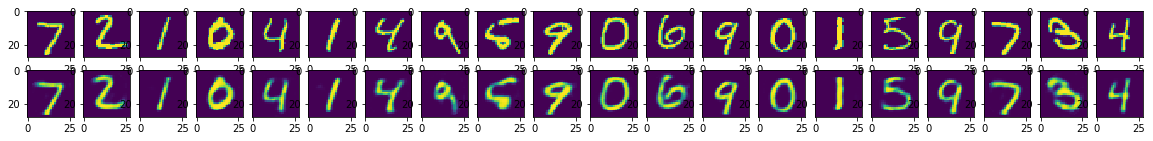

In [25]:
encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})

# Comparaison entre l'entree et la sortie
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
plt.show()

Notre encodeur etant pret, nous pouvons le connecter a un reseau de prediction.

In [26]:
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(entrainement, feed_dict={X: batch_xs, classes: batch_ys})
    
# Test trained model
prediction = tf.equal(tf.argmax(y_cls, 1), tf.argmax(classes, 1))
performance = tf.reduce_mean(tf.cast(prediction, tf.float32))
taux_reussite = sess.run(performance, feed_dict={X: mnist.test.images,
                                  classes: mnist.test.labels})

print("Taux de reussite: " + str(taux_reussite))

Taux de reussite: 0.9172
